In [1]:
#New Code down

In [12]:
# ==========================================
# STEP 1: Imports
# ==========================================
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tkinter import Tk, filedialog
from fuzzywuzzy import process
import zipfile


In [3]:
# ==========================================
# STEP 2: Extract Dataset
# ==========================================
zip_path = "Dish_Images_359mb.zip"     # Your dataset zip
extract_path = "Dish_Images_359mb"     # Extracted folder

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(".")
    print(f"✅ Extracted {zip_path} to {extract_path}")
else:
    print(f"📂 Folder already exists: {extract_path}")

📂 Folder already exists: Dish_Images_359mb


In [4]:
# ==========================================
# STEP 3: Data Preprocessing
# ==========================================
img_height, img_width = 224, 224
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    extract_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    extract_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print("Number of classes (dishes):", num_classes)

# Class labels for predictions
class_labels = list(train_generator.class_indices.keys())

# GPU-accelerated augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.2, 0.2),
])

Found 16313 images belonging to 70 classes.
Found 4042 images belonging to 70 classes.
Number of classes (dishes): 70


In [5]:
# ==========================================
# STEP 4: Build / Load Model
# ==========================================
model_path = "dish_classifier.h5"

if os.path.exists(model_path):
    print("🔄 Loading saved model...")
    model = load_model(model_path)
else:
    print("🚀 Building and training a new model...")
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))
    base_model.trainable = True  # fine-tune all layers

    model = Sequential([
        data_augmentation,
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.4),
        Dense(512, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    # Compute class weights to handle imbalance
    labels = train_generator.classes
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(labels),
        y=labels
    )
    class_weights = dict(enumerate(class_weights))

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)

    # Train
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,   # fixed at 10
        class_weight=class_weights,
        callbacks=[early_stop, reduce_lr, checkpoint]
    )

    # Save final model
    model.save(model_path)
    print(f"✅ Model saved to {model_path}")


🔄 Loading saved model...


In [6]:
#import tensorflow as tf

# Save Keras model first
#model.save("dish_classifier.h5")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open("dish_classifier.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ TFLite model saved: dish_classifier.tflite")


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmposwrh0e0\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmposwrh0e0\assets


Saved artifact at 'C:\Users\ASUS\AppData\Local\Temp\tmposwrh0e0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 70), dtype=tf.float32, name=None)
Captures:
  2199378593552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199378597008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199378597200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199378598352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199378597392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199378597968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199378598736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199378598544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199378598928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199378596816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199

In [6]:
# ==========================================
# STEP 5: Evaluation
# ==========================================
loss, acc = model.evaluate(val_generator)
print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")

c:\Users\ASUS\anaconda3\envs\streamlit_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 15/127 ━━━━━━━━━━━━━━━━━━━━ 3:23 2s/step - accuracy: 0.5611 - loss: 1.5982

c:\Users\ASUS\anaconda3\envs\streamlit_env\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.6442 - loss: 1.2947

✅ Validation Accuracy: 64.42%


In [7]:
# ==========================================
# STEP 6: Single Image Prediction (Top-3)
# ==========================================
"""def upload_and_predict():
    Tk().withdraw()
    file_path = filedialog.askopenfilename(
        title="Select a dish image",
        filetypes=[("Image files", "*.jpg;*.jpeg;*.png")]
    )
    
    if not file_path:
        print("No file selected!")
        return
    
    img = image.load_img(file_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    preds = model.predict(img_array)[0]
    top_3_idx = preds.argsort()[-3:][::-1]
    top_3_probs = preds[top_3_idx]
    top_3_classes = [class_labels[i] for i in top_3_idx]
    
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
    print("🔮 Top-3 Predictions:")
    for i in range(3):
        print(f"{i+1}. {top_3_classes[i]} ({top_3_probs[i]*100:.2f}%)")"""

In [13]:
def upload_and_predict():
    Tk().withdraw()
    file_path = filedialog.askopenfilename(
        title="Select a dish image",
        filetypes=[("Image files", "*.jpg;*.jpeg;*.png")]
    )
    
    if not file_path:
        print("No file selected!")
        return
    
    # Preprocess image
    img = image.load_img(file_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predictions
    preds = model.predict(img_array)[0]
    top_3_idx = preds.argsort()[-3:][::-1]
    top_3_probs = preds[top_3_idx]
    top_3_classes = [class_labels[i] for i in top_3_idx]
    
    # Show image
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
    # Print top-3 + Not Found option
    print("\n🔮 Top-3 Predictions:")
    for i in range(3):
        print(f"{i+1}. {top_3_classes[i]} ({top_3_probs[i]*100:.2f}%)")
    print("4. Not found (Enter manually)")
    
    # User selection
    choice = input("\n👉 Select the correct dish number (1/2/3/4): ").strip()
    
    if choice in ["1", "2", "3"]:
        selected_dish = top_3_classes[int(choice)-1]
        print(f"\n✅ You selected: {selected_dish}")
    elif choice == "4":
        manual_input = input("\n✍️ Enter the correct dish name: ").strip()
        # Fuzzy match with dataset classes
        best_match, score = process.extractOne(manual_input, class_labels)
        print(f"\n✅ Matched your input to: {best_match} (score {score})")
        selected_dish = best_match
    else:
        print("⚠️ Invalid choice. Please run again.")
        return
    
    return selected_dish


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


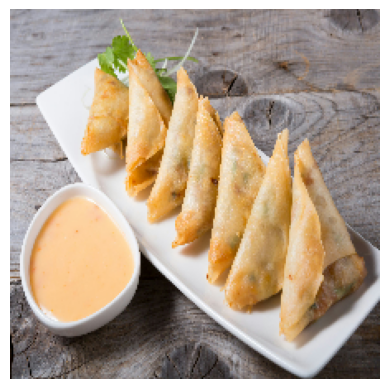


🔮 Top-3 Predictions:
1. samosa (59.85%)
2. grilled_cheese_sandwich (11.13%)
3. bhatura (6.23%)
4. Not found (Enter manually)



👉 Select the correct dish number (1/2/3/4):  4

✍️ Enter the correct dish name:  Samosa



✅ Matched your input to: samosa (score 100)


'samosa'

In [11]:
# ==========================================
# STEP 7: Upload Image
# ==========================================
upload_and_predict()